In [80]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [81]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [82]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [83]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 80 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=80)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [84]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 6479, 'TN': 58873, 'FP': 55871, 'FN': 6433, 'Accuracy': 0.5119383342733597, 'Precision': 0.10391339214113873, 'Recall': 0.5017812887236679, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [85]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 12847, 'TN': 114666, 'FP': 78, 'FN': 65, 'Accuracy': 0.9988798019677885, 'Precision': 0.9939651837524178, 'Recall': 0.9949659231722429, 'desc': 'svm_train'}


### MODEL: logistic regression

In [86]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 12860, 'TN': 114701, 'FP': 43, 'FN': 52, 'Accuracy': 0.9992558124960832, 'Precision': 0.9966674416802294, 'Recall': 0.9959727385377943, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [87]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 12643, 'TN': 103353, 'FP': 11391, 'FN': 269, 'Accuracy': 0.9086607758350567, 'Precision': 0.5260464342181909, 'Recall': 0.9791666666666666, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [88]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 12858, 'TN': 114656, 'FP': 88, 'FN': 54, 'Accuracy': 0.9988876355204612, 'Precision': 0.9932025336011123, 'Recall': 0.995817843866171, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [89]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12912, 'Neg': 114744, 'TP': 10906, 'TN': 114572, 'FP': 172, 'FN': 2006, 'Accuracy': 0.9829385222786238, 'Precision': 0.9844737317205272, 'Recall': 0.844640644361834, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/satoemi/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12912, 'Neg': 114744, 'TP': 0, 'TN': 114744, 'FP': 0, 'FN': 12912, 'Accuracy': 0.8988531678887008, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/satoemi/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

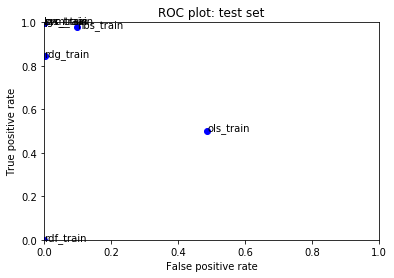

In [91]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [92]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [93]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
10
"

 Germany -  four entries 

You did not respond to my argument at all - please read it more carefully:

The IOC cannot be seen as the single authoritative source on this article, as the IOC itself does not publish all-time tables, and publishes only unofficial tables per single Games. Therefore this article is in violation with WP:No original research! The official source for the German National Olympic Committee (DOSB) does list the Olympic Medals for Germany from 1896 to 2012 → .

There were no official country codes before 1976: Only in 1976 did the IOC start to assign standardized codes. Before that time, the local Organizing Committees of each Olympic Games had chosen codes, often in the local language, resulting in a multitude of codes.

At the Games of 1956, 1960, and 1964 the German team was simply known as ""Germany"" and the usual country code of (GER) was used. Yet, the IOC code EUA is currently applied in hindsight in the IOC medal database

2764
"

Lol I came here looking for ""Internet"". Just saying lol."
* * * * * * * * * 
2766
Sorry, I did not mean to tag ones you have qualms with, go ahead and untag them. Most similar tags stay on if a project is related, but I do not want to step on any toes. Also, I would not have caught that about Anna Nicole Smith, thanks,
* * * * * * * * * 
2768
User:Canterberry 

I noticed you had had dealings with  previously, so I thought I'd drop a quick note to you:  I was archiving my talk page today and I found a section where Canterberry and I had exchanged views.  Included was an analysis I did of a month of his edits on en.  I've no idea whether it would be useful to see, but I've preserved it at User talk:Ssbohio/Canterberry.  I had no idea what all he was up to when we spoke.  He just seemed like the garden-variety guardian of his nest.  ohio
* * * * * * * * * 
2912
This reference is false and has been retracted by the Texas State Board of Pharmacy. I can send you a copy. Thank you f

5180
I was thinking about the link and I will write a plot for the radio episode shortly.
* * * * * * * * * 
5268
I restored the previous version. It is probably worth getting into the parent company briefly, however. t/c
* * * * * * * * * 
5327
"
Hi, thanks for the message. However, I doubt my signature is of interest to anyone, and if you want to write an @KageTora message in a thread, you can see it right there in the editing section, no bigger or smaller than anyone else's.  (TALK) 
Dîd you even read the template at the top of my userpage? I will admit that Courier New evens the playing field slightly, but that is not the point of a signature. I only ask that you make the font size slightly bigger, as your chosen font is not easily legible at small sizes. change|talk to me "
* * * * * * * * * 
5363
"
 I don't know what the other fellow's problem is, but i would like to state the obvious—CNN IBN is not a primary source in this instance.  Holla at me!  "
* * * * * * * * * 
5404
File:

8580
"
Apologies, but you'll have to find a WP:RSbetter source, that's all there is to it.  Another editor has also questioned one of the sources on another article.   † "
* * * * * * * * * 
8586
"

 Requested move 

Asrani (actor) →  – Currently, the title ""Asrani"" redirects here as the Bollywood actor is the primary target. Hence the article should be moved. §§§§ {T/C} "
* * * * * * * * * 
8602
"

 Grades of ABUs 

I don't really know how to cite the information that I just put in about the grades.  I found out this info because I am in the Air Force and went to a vendor show today.  A rep from ""Dakota Outerwear Company"", which is a authorized vendor of ABUs, showed to me and explained the four grades of ABUs.  The different in the colors are very slight and hard for even me to tell (a color blind person might have problems).  The difference comes from the fact that the Air Force wanted to lower costs so they used the dyes longer which means that the first batch dipped in the dye

11540
"

persistent vandalism
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  ( talk | contrib) "
* * * * * * * * * 
11697
Merger proposal 

It is proposed to merge LP Norm into this article.  It's really just a brief definition, which is already found in the bigger article.  Only additional information is the term Chebyshev norm, which incidentally redirects to Uniform norm.
* * * * * * * * * 
11735
Your opinion 

Hi. I am retiring from Wikipedia soon and I am not going to contribute anymore. But before I do, I would like you to see the List of Lebanese people article and, and the conflict that occured between me and user:Lcnj. As a major contributor to Lebanese-related articles, your opinion and your say in this would be of great help and/or influence. As I said, I'm done with Wikipedia. But for the sake of Lebanon and this article, please compare between mine and that of the user mentioned above and g

* * * * * * * * * 
14443
"

 You had offered... 

 SSB,
 A while back you had offered to be an intermediary for SqueakBox and I, as we had mutually agreed not to post to each others' talk pages (an agreement of which I am still abiding at least). Well, I would like to ask his assistance with a little Wikipedia-related ... project. I need the help, it may be a little fun for him, and I am totally in good faith (and need) wanting to enlist his assistance.
 If you might communicate to him that I would like to run an idea past him, I would appreciate it. If so, I'll do it as he wishes; on his talk page or on mine. If not, that's fine too and my feelings won't be hurt.
 Thanks!!!  •   •  • 01:13 (UTC)  27 Mar '08"
* * * * * * * * * 
14457
"

 Let's make one thing clear.  I never agreed to anything with you.  All I did was back off because as I said before, when a 6-year old keeps screaming for a cookie, sometimes you just give them a cookie to shut them up.  None of the changes I made viola

17548
Nintendo Revolution is still a code name , so i changed the first sentence
* * * * * * * * * 
17559
Factual error in this article 

I would like to report a factual error in this article. The error is that it says that WJ Clinton's presidential term began at the end of the cold war. Clinton served as POTUS after the cold war had already ended. This can be confirmed in the wiki article (as well as many, many other reliable sources as well). I request that this article remove and correct this erroneous entry in order to be accurate and correct (an important and very valid Wikipedia motivation). Clinton's term began in 1993, this is two years after the end of the cold war. The George H.W. Bush BLP should also be edited for the factual entry that GHWB served as POTUS (seeing that this is important and was included in WJC BLP) at the time that the cold war ended. The fact that Clinton had absolutely NOTHING to do with the cold war may or may not be added for clarity on this very impor

20112
The problem is that you are assuming that someone not signed in is doing so for purposes of doing bad things or is in itself bad. There is no rule saying people have to sign in  quite the contrary, in fact, and a good thing too when there is no way to guarantee you'll be signed on. When I just stop by and make edits after Google searches on whatever I am looking for brings up an article that I fix, I have no way of knowing I am not signed in. And when you attack me for not signing in and raise a big fuss, I will not sign in just to further prove to you that you have no clue. Your attitude is clearly not neutral, you are raising a fuss about something for no reason whatsoever, and continue to do so even after you are educated to the contrary. At this point it is just harassment. Stop bugging me about rules that only exist in your head. 68.47.175.159
* * * * * * * * * 
20207
Was it YOU that got me temporarily banned, in response to reporting you for using multiple ID's to avoid get

23309
It's still there. The section was retitled Prisms and the nature of light. It isn't really what you're looking for.
* * * * * * * * * 
23398
Okay, I'm going to finish the process, and it simply won't be perfect because of the apparent limitations of the software or of the design of the software. I am leaving Mamadoutadioukone alone because it's the way I want it. I may make a note in the open report just so others know what happened and in case I'm not the one who finishes clerking it. I will replace the open report in Sibtain (which, as I said, is a duplicate of the archive) with the open report at Mamadoutadioukone using copy/paste. I will then make a note in that report. I think it's better to have the note in the report than in the talk page because I don't think most of us look at the talk page. I'm going to do that now because I have to take off this morning and I don't want it sitting the say it is.
Thanks again for your help, and I apologize for causing such a commotion. 

26144
delete as soon as you can
* * * * * * * * * 
26154
Thanks for experimenting with Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.  — Z. 2005-12-19 22:43 Z
* * * * * * * * * 
26265
Any luck finding the ID of the anon?
* * * * * * * * * 
26271
I don't reach to any consensus with you or another user about this subject, same warning to you.Thanks.
* * * * * * * * * 
26385
"

 Happy Holidays 

 Happy Holidays, fellow Wikipedian. ) TALK "
* * * * * * * * * 
26407
":::::It is not a question of whether Soriano can or cannot pay for the plain tickets of the so-called awardees (of course he can, he is a big time swindler and owns many businesses) because the ""awardees"" would gladly pay the tickets themselves. It is also not true that Eli Soriano cannot pay the bail for his homosexual rape case, being a fug

28692
Walter LAMAR Scott 

Please read my request on the talk page and fix the name, they have his name misspelled. I provided a source and everything.
* * * * * * * * * 
28693
)
If you want to translate sources, see Wikisource. That's a great effort to have. It doesn't mean that you are suddenly more competent at the text you are translating than anyone else, and it certainly doesn't give you the right to attack editors.   
In addition to lacking a biography for Emperor Ling of Han, the Records of the Three Kingdoms carry no biography for Emperor Shao or Emperor Xian of Han. None of the Han ruling house have biographies in the book. By your own logic, gauge00, this means the Records of the Three Kingdoms cannot be said to start until 220, which is clearly false. I will state again that carrying a person's biography is neither a sufficient nor necessary condition for recording events that occurred during their lifetime.   
 Good point. (  21:06
* * * * * * * * * 
28721
Please stop. If 

31554
, greatest moments, and other specials. To many of today's viewers, BBC 3 may be the home of Dr. Who.
* * * * * * * * * 
31590
"
I just saw what you wrote about me in the newsletter. LOL (I don't usually do that, the LOL bit, but I must be demented today)! I have received another request for a newsletter, so I've got to go make that. 110 "
* * * * * * * * * 
31601
"

Could you please reduce the block back to the original week, if I promise to not edit any pages until that time has run out. I feel very guilty about what I have done. It is just that my computer constantly changes my IP address and I always forget to log on. So I often forget that I have been blocked and I go and edit pages under my ""new"" IP address. Trust me, I have no idea how to change my IP address intentionly. And the reason I have been having edit wars, is that when I believe in something, I like things to go that way. But I promise that I will try and change my ways. I want apoligise and compliment you fell

34283
An admin of dreamhosts wikipedia site has tried to recruit meat puppets to this wiki article to shower this company with praise and turn it into a big nice free advertisement. Dreamhost is obviously no dream but I don't really think that it's apropriate that we make a wikipedia article that gives one the idea that dreamhost is just one big scam. The question then becomes, what exactly can an article about dreamhost contain and the answer to that is simply not a whole damn lot. I therefor think that it's best that this article gets deleted.
* * * * * * * * * 
34380
REMOVE IT OR BLOCK ME NO THER CHOICE.
* * * * * * * * * 
34492
Edits to Zakir Hussain (musician)
Thanks for contributing to Wikipedia.  Unfortunately, the commercial links/content you added  were inappropriate, as Wikipedia is an encyclopedia and should not be used for advertising or a collection of external links.  See the welcome page if you'd like to learn more about contributing to the encyclopedia.  Thanks!
* * * *

36935
High School 

Did you know that Salisbury couldn't read in high school? I am friends with Kevin Brown, one of Sean's teachers at Orange Glen when he was a student there, and he said that Sean needed special tutors because he couldn't even read!! Seems funny that nobody ever talks about thatit's really an amazing story!!
* * * * * * * * * 
36984
Internal Links for noted professors and Alumni 

I just added Nora C. Quebral to the list of noted professors and Alumni, and realized, most of these people have their own wikipedia entries. Shouldn't there be an internal link to them?
* * * * * * * * * 
37031
"
 Oh, oh wait, even better yet: Touting your own art on this site is ""good practice"" but adding pictures of your sacred symbols is ""trolling."" What in the hell. They're both art. Primetech "
* * * * * * * * * 
37051
An editor pushed me off the article in the way it was organized. Feel free to raise the issue on the article's talk page, or just add it.
* * * * * * * * * 
37053
"


* * * * * * * * * 
39537
Proto languages==
This is the most probable development:
 Proto-Uralic: 4000 BC
 Proto-Finno-Ugric: 3000 BC
 Proto-Finno-Permic: 2000 BC
 Proto-Finno-Volgaic: 1500 BC
 Proto-Finno-Lappic & Proto-Ugric: 1000 BC
 22:09, 15 Dec 2004 (UTC)

==
* * * * * * * * * 
39556
Is that your new strategy to claim there is no citation?  His ministerial licens is sourced and the people who signed it are sourced but you removved it anyway.  You are playing a game.

You have never listened to his teachings based on what you write.  He says God created all the races and intends them to stay that way.  He then went into a story about he accidentally crossed cucumbers with canteloups and the result was something unedible.  After that story, he said therefore God wants things pure.

In Deteuronomy 23:2, he specifically said it refers to people of two different races and if you violated that law then you can be forgiven in this dispensation of grace.  

You started all this by saying 

40906
"

 Autism's False Prophets 

  The Writer's Barnstar What a nice article on an important book, Autism's False Prophets. I wish I could write articles so effortlessly. (At least, you make it seem so effortless.) Thanks.   "
* * * * * * * * * 
41005
Many Bantu languages have only a handfull of adjectives. Others, like Kiswahili, have none. As you can see, there is more to linguistics than English and this article should reflect other views. Please tell me of your responses on my talk page. User:ZyXoas.
* * * * * * * * * 
41019
Removing Warnings 

Thank you for the unblock, however, I would like to know what the deal is with the warnings? Like, do they go away eventually? I mean, they're just cloggin up my area and I would like them to be gone. I've seen them, acknowledged them, been blocked for attempting to clean up my page and now I would just like them to be gone. Thanks.
* * * * * * * * * 
41028
odd rv  

Take another look at my edit of Girls Gone Wild and tell me why a revert

42184
2008 (UTC)

=Virgin Media
Indeed...   08:52, 14 July
* * * * * * * * * 
42193
In other words, you knew exactly what you were doing. You did it knowing that there was a thorough discussion and a clear consensus against you. Next time you try a stunt like that, I'm bringing it to ANI.
* * * * * * * * * 
42248
What why, please could you?
* * * * * * * * * 
42255
\lt in  

the symbol < gave in  a parser-error when using MathJax last week. Thus I 'm using a pre-debuged version and typed new stuff with Tex-notation \lt. I don't know whether the new update of MathJax is already rolled out publicly.
Sorry, but \lt should work in standard environment, or am I mistaken? ~~~~
* * * * * * * * * 
42305
"

(talk and  are same user vandal without any reason again
This users vandal in the pages of this ""File:Iran ethnicity map2.png"" as I explained you in the abow I corrected the mistakes of previous map according to a map published by uni of Texas and put the sources there,YOU MAY COMPARE THE 

43537
I'm sorry you were born a yank, that isn't my fault but I hear Suicide is a sure fire cure ) please try it and get back to me94.172.127.37
* * * * * * * * * 
43559
Well, dark green is the color of Islam, so light green does sort of make sense. Is it possible for you to make a new version of the map that shows pluralities/equal religions somehow? And also, its accepted that Lebanon is a Muslim country, coloring it in as Catholic would be misleading.  Talk|Contribs
* * * * * * * * * 
43656
I'm not an admin, so I won't be the one making a decision about your unblock request, but it appears that what you state in your unblock request isn't true. Here's the chronology:
You recieve the warning about your improper use of reviewing templates on AFC submissions: 
You blank the warning: 
You then continue to improperly template the AFC submissions: , , .
You were then blocked.
Therefore, it appears that you did not cease your involvement with AFC following your warning.
* * * * * * * * * 


45397
":Thanks for the second award. Now where is Bart? 

"
* * * * * * * * * 
45411
Ducking opponents

Due to his penchant for taking the easy fight in his prime-Benn, Collins, Michalzewski, Hopkins rematch, He did fight Toney and mediocre Ruiz. 24.239.153.58
* * * * * * * * * 
45489
, 31 January 2007 (UTC)

yes but i like the music video-ness 2 haha the guy is reallllly pale its awesome haha <3 00:53
* * * * * * * * * 
45520
Hello, and welcome to Wikipedia! We welcome and appreciate your contributions, such as  London Fire and Emergency Planning Authority, but we cannot accept copyrighted text or images borrowed from either web sites or printed material. Perhaps you would like to rewrite the article in your own words.  For more information, take a look at Wikipedia's policies and guidelines.  Happy editing!
* * * * * * * * * 
45533
Gwen Gale: I am sorry but you have pointed at nothing which indicates why I was blocked, when you did it.  You stated it was a preemptive block.   If you 

48785
Some of the sources listed as NY Mag, CBS News, Fox News, an interview with Leighton speaking of the subject directly in Teen Vogue and US Weekly, a TV Guide interview, an article in the San Francisco Gate, the newspaper from the town Leighton grew up in (Naples Daily news).  If you do not consider those reliable sources, you have a problem.  If you want I can find 20 more sources from valid/reliable newspapers and magazines.  Everything is valid and sourced and should not be removed as it is the story of HER life.  Wikipedia is an encyclopedia for facts, and what is posted is FACT
* * * * * * * * * 
48870
Thank you for pointing out that the [edit] buttons were not working for my talk page, it seems someone placed a __NOEDITSECTION__ there by mistake. I ended up adding a FAQ (Nubio 149) for you question.
* * * * * * * * * 
48917
My response to the recent and undiscussed edits to the article: The video at the bottom of this page demonstrates how the Touch is considered to be one o

51899
ThisYou are 22 years older than your husband! You are an old cougar!ions
* * * * * * * * * 
51912
Hi. The routes to Japan are often mis read. First, I had the argument that JAL flew to Tokyo, not JALways. But now I would like to challenge a route that Jetstar takes. It said the Jetstar flew to Kansai from Brisbane. This is true but you must connect through Sydney. Although you would stay on the same aeroplane, the flight number between BNE-KIX changes in Sydney meaning it is not a direct flight. EG: Flight 001, SYD-KIX. FLIGHT 002, KIX-SYD via BNE. That is how it works. If you are not sure, please check Qantas schedualing. I wont edit the page now in fear that I will be banned.
* * * * * * * * * 
52003
Hi, Please make a username if you want to be an active wikipedian.
* * * * * * * * * 
52005
"

Curious but unreferenced

Pig War is curious and has a great potential! that is, the article. Two words of note:
 Don't insert links to wikipedia articles in footnotes. Use direct links t

54760
Headlines 
Im testing something

 Something about the headlines? 
Headlines.
* * * * * * * * * 
54787
Source 2:  -> go to Waffen-SS & Polizei -> go to SS-STURMBANNFÜHRER -> go to D-F -> scroll down to ENDRESS, Hans.
* * * * * * * * * 
54815
, for this, Swift's superman song is in other section and not in 'as lead artist'
* * * * * * * * * 
54872
As I was the first to object, leet me also be the first to say thanks for adding the references for the Sayuki paragraph in the Geisha article.
* * * * * * * * * 
54894
Proposed deletion of FK Šumadija Arandjelovac 

You contested the proposed deletion of this article on the grounds that the club had played in the Yugoslav Second League and the Yugoslav Club. Can you provide sources to confirm this? Thanks.
* * * * * * * * * 
54900
"

 Past Masters vs. Rarities 

I'm creating a chart for my own use that includes U.S. albums, since there are so many differences in the early albums. As a U.S. fan, I'm faced with the issue of whether to have

Garry Wills (again....)

from the WP article , a recent name, perhaps missspelled above here, reappears:

A few Catholics refuse to accept papal infallibility as a doctrine of faith, such as the theologian Hans Küng, author of Infallible? An Inquiry, and historian Garry Wills, author of Papal Sin.
* * * * * * * * * 
57738
i just started the law inforcement page of cape verde
* * * * * * * * * 
57756
May 2007 (UTC)
Thank you for looking into and attending to this issue.  01:46, 3
* * * * * * * * * 
57769
Also please see Talk: Bronx/Name#Start a Request for Comments on renaming now and Talk: Bronx/Name#Wait before reopening the renaming question (how long?)  for several editors expressing opinions pro and con about restoring the name of this article to The Bronx. The question there was intended to be whether the RfC should be opened now, but several people expressed their opinions on the actual question at hand as well, and those opinions should be included when considering the outcome o

59959
"== Ms. Dynamite is not webcomic, she is some stupid singer ==
I am very disappointed in ""dolty"" Wikipedians who has no common sense to make a bad decision to redirect to Ms. Dynamite when Miss Dynamite was mentioned in other articles as a webcomic. If Wikipedian won't remove redirect then he will be stupid enough to be not smart. Redirect command must be removed. Ms. Dynamite is not part of webcomic, she is singer. what dolt! Wikipedians may be computer geeks but none of them have common sense that make them dumb.

"
* * * * * * * * * 
59977
"
Delete or merge.  The information is not relevant to anyone unless they are looking for information at the library, in which case they would use the library's website.  If anything, combine all the subpages into a single page.   (talk • contribs)  
 Having the LCC on Wikipedia is awesome. I use it a lot!  Wikipedia presents the LCC in a way that it can be easily studied: Wikipedia's version of the LCC is linkified, providing instant desc

62545
Possibly unfree Image:Juan Gualberto Gomez airport.jpg 
An image that you uploaded or altered, Image:Juan Gualberto Gomez airport.jpg, has been listed at Wikipedia:Possibly unfree images because its copyright status is disputed. If the image's copyright status cannot be verified, it may be deleted. You may find more information on the image description page. You are welcome to add comments to its entry at the discussion if you are interested in it not being deleted. Thank you.
* * * * * * * * * 
62575
Well, I don't know what those arguments could have been but it is ridiculous to have such a colorful map for the introduction, no offense. That degree of detail must go somewhere else in the article. See the British Empire map, the Portuguese empire map, the French empire map, etcetera etcetera.
* * * * * * * * * 
62626
It is hard to be super nice to you when you block me from editing FOR NO LEGITIMATE REASON. You did not even warn me or anything this time. I EVEN TOOK EXTRA TIME TO

* * * * * * * * * 
64890
VirtualSteve, you are making personal attacks towards NisarKand, stop your obessesion with him. You are pathetic and should be ashamed of yourself. Not just that but you're helping the banned vandal User:Anoshirawan (a.k.a Inuit18), do a checkuser and it will confirm this. Now, this obviously makes you the silly one. By the way, NisarKand is a millionaire from the United States, he has better things in life to do than to work for free as a Wikipedia editor.
* * * * * * * * * 
64891
Thanks!  Actually I knew this but got it wrong in this instance, so thanks for fixing it! —  June 28, 2005 12:55 (UTC)
* * * * * * * * * 
64902
how i can read the books on wikepedia
* * * * * * * * * 
64913
Neutral
I think that this page is neutral enough. The only non-neutral things are quotations from other sources.
* * * * * * * * * 
64922
Well, it's kinda both. Kyle notices it from reading the contract, and Peter Moore confirms it. I amended the passage in the article to clarify 

67160
Well I will use my user page then, don't tell meyour gonna remove it too, because that will piss me off and drive me nuts. Also I am not making a personal ttack on Jimmy wales, I am saying he is a bit to greedy dont you think? He's got 6 million dollars already and now he's asking for more.
* * * * * * * * * 
67201
Please help.  User Mongo  has been staking me around wikipedia over the last day, on the 3 different articles I've been trying to add to.  Please help with asking he/she to discontinue stalking me.  Demonstrates inappropriate interest in what I'm doing.  Also, I'm using a source from England, Collin Wallace's Everest history and Everest news website.
http://www.everest1953.co.uk/about-us.html
http://www.everest1953.co.uk/articles.html
and this in particular
http://www.everest1953.co.uk/speed-climbing-records.html
The source is well established and well respected.  Also, many news sources are self published, such as Explorers Web, which is published by 1 person, Tina Sj

68399
Category:Senior wranglers 

I meant for Category:Senior wranglers and Category:Second wranglers to be discussed together, but didn't make it clear that I was including Category:Second wranglers in the same discussion.  If this makes you want to change anything you have said or add anything new, please do so.  Sorry for the confusion and thanks for pointing this out to me.
* * * * * * * * * 
68426
Merry Christmas, A Nobody 

Thanks for the gift and wishes, A Nobody. A very Merry Christmas to you too! Best.
* * * * * * * * * 
68436
Martha Jones 
Hi Zythe, I don't know how to use this 'talk' business so I hope this message gets to you. No hard feelings. I'm glad you enjoyed my paper. I was made aware of being cited here when I received an angry email from someone arguing with me - but actually what they were saying is what I was saying in the paper. They had misunderstood my argument based on what was in Wikipedia, hence the need to make changes. I feel totally honoured that you wou

70797
WikiProject V8 Supercars
Hi, I was having a look at some of your edits and thought you might like to join WikiProject V8 Supercars. Let me know what you think. All the best,
* * * * * * * * * 
70813
The FCB is done. That's how it should look - tight, succinct plots with accurate sources and correct tenses and no flipping in and out of universe. The Phalanx image was a casualty as it really offered nothing new: that's just a pose shot of Ultron, and not too dissimilar to the main image in the SHB. The imasge to add if anything is the shot from the Iron Man cover, which I will try to find as it shows yet another different version of Ultron. The Phalanx info was trimmed to what is necessary. There's no need for unnecessary plot extrapolation (clumsy, usually with POV and also a spoiler) when the gist, offering a teaser, is sufficient. As to in and out of universe, references get bracketed and stay out of the FCB information, and creator comment is for the PH, in this case on the art

73245
Recent Edit

1. Moved the Hariakhan Baba paragraph above Post-Yogananda Claims. According to that entry Hariakhan Baba taught from 1860 (before Paramahansa Yogananda was born) to 1924 (before the publication of the Autobiography of a Yogi in 1946). People accepted and revered Hariakhan Baba as the Babaji since pre-Yogananda times. The timing of his appearance also coincides with Lahiri Mahasaya's Kriya Yoga initiation from Babaji (1861).

2. Corrected a minor spelling error from Hari Dasa to Hari Dass.

3. Added Roy Eugene Davis' name and book as support for the Mahavatar Babaji/Hariakhan Baba theory. Basically,  to show that there is someone from the lineage of the author of Autobiography of a Yogi who agrees with Dass and (Mahendra) Baba's conclusion. Roy Eugene Davis was ordained by Paramahansa Yogananda himself in 1951. So, for someone like him to agree that this Hariakhan Baba is the same as the Mahavatar Babaji mentioned by his Master and venerated by all legitimate kriyaba

* * * * * * * * * 
74154
"

This has already been fixed, but for those that are unaware, I didn't edit that page; this note was left here by mistake. matrix "
* * * * * * * * * 
74288
":::::if just the fact that it hasn't existed before means we shouldn't ever start having it, we would not have democracy right now, would we? also, there has been minor instances of anarchism. also your post was completely irrelevant. this is not about the viability of libertarian socialism, but wether or not it is a syncretic politic· Lygophile has spoken 
"
* * * * * * * * * 
74325
"

 Please do not vandalize pages, as you did with this edit to Bonobo. If you continue to do so, you will be blocked from editing.  gabsadds "
* * * * * * * * * 
74349
"

You're both wrong. Stop this useless shouting match immediately. If you don't stop, I'll block you, and this goes for you both. -  (conspire | past ops) "
* * * * * * * * * 
74462
Why dont you take you do gooding goodytwo shoes way and play on some other s

76162
"

You're right that ""King of Salt"" would need a reference. The same is done for marketers of the wolfberry, who claim that it was called ""happy berry"" in Chinese; no source has ever been found for that. Regarding the Himalayas, the article Himalayas does state that the system includes mountain ranges in other nearby countries, including Pakistan.   "
* * * * * * * * * 
76199
Why do you love porch monkeys?
* * * * * * * * * 
76213
Request Removed. Thank you for your contributions. Unfortunately, creating new articles is beyond the scope of the Requested moves process. Please submit your request to Articles for Creation. You can do so by adding {{subst:AFC submission/submit}} to the top of the article. Feel free to contact me on my talk page with any questions. Happy editing.
* * * * * * * * * 
76296
I think the general Wikipedia principle is that an article headline should explain the article.  In this case it looks like the article should be at A5004 road but in this case I 

79137
Much thanks for asking... will drop by there in a bit. Very busy this week, so I won't be on as much. Best, Rob  | TK/CN
* * * * * * * * * 
79214
"

It's all good; I probably should have been more clear in the first edit summary.   Talk to me "
* * * * * * * * * 
79242
reference as the alternate license by Orthodox wiki being in conflict with exporting to Wikipedia.
* * * * * * * * * 
79372
Thanks

Thank you for your support of the Belarusian people.
* * * * * * * * * 
79428
Harold Larwood
Don't know where you are in the world, but as promised I am notifying you, together with appropriate link here, that Harold Larwood now sits atop the FAC pile, awaiting judgement. I hope the cruise went/is going well, and look forward to your comments.
* * * * * * * * * 
79491
activities with a free man was beheaded, he who allows himself to be used by another man had was fined with half of all his fortunes and belongings and he was not allowed to write any testaments for what he had left. He w

81809
"**NM I belive. I've converted them as well.White Shadows There goes another day 
"
* * * * * * * * * 
81813
" I didn't say nothing about leaving. I don't see you ""verifying"" anything. Just more YAPPING!"
* * * * * * * * * 
81821
dna tests/ancient egyptians 

Hi

Do you have any citations to articles about the DNA tests performed on ancient egyptians?   Based on the other comments on your talk page it looks like it may be vandalism, but just wanted to give you a chance.

Thanks
* * * * * * * * * 
81889
YGM 
YGM on your mdennis account. -
* * * * * * * * * 
82057
There are still numerous errors and omissions in the article. I have just noticed that the article is claiming that 'The house was closed as a crime scene from 2 November 2007 until April 2009'. Technically true, perhaps, but omitting the undocumented entries by police and the burglaries of the cottage during that period. On the other hand, the article now seems to be claiming that the death of the victim occurred befor

84242
About the Bugeac image

Ok sorry to answer so late. The map was originally created  by Anonimu and he based his map exclusively on the Soviet census of 1989 if I am correct. He did not post it on the article, he just suggested it as a possible map, however everyone sort of ignored it. I contacted him and inquired about it. I took the map and changed it in areas where i knew for sure from census data from 2001 that there were mistakes. Besides the census, the sources I used were  and  as well as this site for the actual map .
* * * * * * * * * 
84296
"

 Nowhere 

Censorship-by-reversion will get you nowhere. The ""Deletionist Ahoy"" string is in your history and the bot will see it there in the fullness of time. Regards   "
* * * * * * * * * 
84302
Thanks for replying on my talk page.  FYI.  Unless someone can come up with a good way to decide which flag to use, then the current consensus will be to remove the flags from the lists. I came up with a scheme for the Nobel Prize in P

86537
"
On that off-wiki connection comment, I said it just because I found it curious that both Omer and Cihsai have access to Simonian's book ""The Hemshin"". It's a new and still hard to find book - few libraries will have it, and it's very expensive to buy. The only reason I have a copy is that the author kindly gifted it to me.  "
* * * * * * * * * 
86611
Nope - You are wrong! When a court 'dismisses the charges', that is a success. If I'm not mistaken, the courts don't publish instances where they dismissed the charges, and that is why it appears as if no one has successfully 'won' against the courts.
* * * * * * * * * 
86662
Wow! This is very helpful; I'll definitely try to adapt the lead accordingly. I must confess that the importance of the double meaning of dictator had completely eluded me and now that I think about it I do see that it's quite relevant. I had also failed to pick up on the I, I suppose the article could make this more explicit? Let me try to summarize your po

89538
and batiushka loved russian Orthodox church
* * * * * * * * * 
89549
Tabley House 

Hi Peter. Yes, you're quite right, it's not totally clear when the house started to be used for elderly care services. But this source suggests that it was at least as early as 9 April 2009. In fact, it looks like the report from that date was the first one.
* * * * * * * * * 
89559
(I didn't even read the name... oops)
* * * * * * * * * 
89622
"I think the confusion is that ""capital controls"" is being thought of as control over the out-flow of money. What has been recommended for developing economies is control over the in-flow, so that ""hot"" money has a more difficult time getting in, but legitimate investors don't worry about being able to get their money out.   

"
* * * * * * * * * 
89650
, what's the source of September 26, 1181 as St.
* * * * * * * * * 
89676
:Ed Windle
Welcome to Wikipedia! We could really use your help to create new content, but your recent additions (such as Ed Windl

91987
ambassador program and IRC 

Hi! I responded on my talk page.
* * * * * * * * * 
92000
Reception Update is needed:
http://www.sputnikmusic.com/review/53839/Game-Jesus-Piece/
* * * * * * * * * 
92043
"
Yes well, with Timbouctou blocked by the admins we may actually do so.
I find your claims very possible, but again, what is required are reliable sources, not claims. Even if we assume you are correct in that this was the ""first"" flag used after the HDZ came to power, this is not what we're looking for. What we are looking for is the flag that was predominantly in (official) use. I.e. even if the white-square-flag was used the first time, which I admit was likely the case, that does not necessarily mean that it is the version of the flag that was used afterwards in any significant measure - particularly since the Croatian government very soon afterward adopted an official flag with the red-square-first chequy (to distance itself from Ustase symbolism).

To be perfectly frank, the 

92544
Please stop your disruptive editing. If you continue to vandalize Wikipedia,  you will be blocked from editing.  now
* * * * * * * * * 
92597
I was sent a message by  and I'd like to thank him for doing so. In my humble opinion he should be un-banned. It should also be noted that I did not vote in accordance with .
* * * * * * * * * 
92674
This just seems to need a lot of stylistic editing. Many run-on sentences, unclear paragraphs, and a lack of a strong 'theme', I suppose - I came here knowing nothing about this person, and left....knowing a little more but feeling as if much of the information was lost or muddled due to unclear writing. Some re-writing and reorganization will greatly improve the article and make the information within more accessable and easily retained.
* * * * * * * * * 
92702
"
HAHAHA what a lovely comment!!! Hehe!!!
Hey when will you restore your UP?  • Talk2me "
* * * * * * * * * 
92711
I have made similar comments, all of which have been removed by this 

94672
"         The quote:  ""Growth, Unity and Progress"" provides a fitting description of this municipality at the start of a new century.""  is CLEAR evidence of npov writing.  No one is resorting to childish rhetoric here except you.

"
* * * * * * * * * 
94685
What's the problem with this author? He is a famous historian in his country?
* * * * * * * * * 
94884
I did quote a good source 

I quoted QRZ.COM which is an amateur radio callsign database and I also linked to Tim Gaines's Amateur radio website. Your apology is expected promptly and my changes will be restored, or you will be talking with my attorney!
* * * * * * * * * 
94918
"

Oppose Per TheFreeloader. The proposer seems to be frustrated by the massive waste of time, effort and other Wikipedia resources on a trivial looking issue. I fully agree. But the proposer seems to be proposing what he criticizes others for doing, and he proposes to do it on a mega scale. Well, I fail to see the sense in doing so. However, the FA

97478
well, I didn't know about Uncyclopedia when I made Myke's page. and believe me, to the people I'm sending it to, it's funny, even if it would seem insulting. I;ll try posting it there, but if it's anything like wikipedia, I doubt it. Looks like you guys are going to lose business to Encyclopedia Dramatica. X
* * * * * * * * * 
97525
"

 The correct spelling is ""smart aleck"" 

Thank you. Come again, teenager. 68.45.180.34  "
* * * * * * * * * 
97573
Hello there, you still around??? 
hey, was just hoping that you may still visit here? please leave a message if you are ).
* * * * * * * * * 
97714
I read this distinction to say a difference between collateral damage, and a policy of government to kill people.  The example used of targeting munition factories stand in contrast to Dresden.  The raid on Dresden targeted civilian population, it was not the result of collataral damage to German war industries.
* * * * * * * * * 
97732
Jonathan will round house kick Chuck to the face any

100471
"

 Bay of Pigs air support 

I removed the sentence ""President Kennedy had withdrawn support for the invasion at the last minute by canceling several bombing sorties that could have crippled the entire Cuban Air Force"" and someone re-inserted it with a reference to a rambling article on a far-right wing web site.  An article which of course gives no references to first-hand accounts, documents etc. about this, we just have to take the word of a conservative named Humberto Fontova.  But beyond this, Fontova doesn't say anything that supports the idea that Kennedy withdrew support that had been pledged, canceled sorties that had been scheduled and so forth.  Fontova's article does not fall under the Wikipedia:Reliable sources category, but more importantly, Fontova is not even a source for the allegations made.  This is being remove again.  "
* * * * * * * * * 
100573
Boston Asskickers 
it should be noted that the recent dominace of other teams by the Boston Red Sox has earned 

103031
Stop Wiki-stalking me 
Some of my changes were factual.  Other people are allowed to change things on wikipedia.  You need a wiki-life.
* * * * * * * * * 
103092
"
Preity Zinta FA
Hi there. The Preity Zinta article has recently achieved A-class status. Due to the wealth of support I have decided to now nominate for an FA class article which I believe and judging by the comments of others is pretty much up to. In my view it is better than some existing FA actor articles. I would therefore be very grateful if you could give it a final review in your own time and leave your comments and views at Wikipedia:Featured article candidates/Preity Zinta. Thankyou, your comments are always valuable. ""Talk""?  "
* * * * * * * * * 
103093
"

 Please do not vandalize pages, as you did with this edit to Optical fiber. If you continue to do so, you will be blocked from editing.   (mailbox) "
* * * * * * * * * 
103150
Is it not possible to accept that the merge argument was lost. Oppose them and

105889
"Any rate, your editing on Peter Roskam Bio  article is going to get contentious again
due to your tenuous editing..  see example is this what you want...??? Why can't you be content with NPOV rather
then pushing your political agenda??? Is you hated for Republicans and Pete that great that you compromise principles of fair play, free speech, NPOV??? Is ""ends justified the means"" is the only principle you believe? Is this so important to you that you have to resort to Chicago street thug tactics, because  you your arguments can not stand on merit alone??? Why do you, and your Democratic friends have to resort this?  If you have issues with the Republicans and Pete, Then get involved with your local Democratic organization, rather then lie in your basement and spew your hate and lies???  Any rate, I be watching....""

You lies and moral relativism clouds your view of reality around... BTW... I have a C&D; filled out and ready to file in Elgin, should you continue this implied C

108614
Thank you for the response, I won't edit the article any more.  I understand your points, but as someone with a degree in both Astronomy and Physics, I still find this section irrelevant.  It detracts from an otherwise nice article.  If other Wikipedia users don't agree with me,  that's fine.  You can argue that the Dr. Who edits are encyclopedic, but they are definitely not scientific in nature.  Maybe that doesn't matter, but that would be a shame, since this is an article about science.
* * * * * * * * * 
108679
"

 ""Yargh"" interjection article 

You delete my article, saying that this was du to a lack of sense. But this article should be part of wikipedia.

First thing first, read article before complaining.

Second, article is far from vandalism, take time to write and as not being written for stupidity use.

Third, I personnaly search for website with de definition of Yargh and didn't found, I finally came here which is my source for every thing and I was so disapointed 

111481
It is not quite the same thing, firstly I write my own replies, and secondly I have participated in discussion about BJCP on this page, quite clearly giving my reasons for wanting the BJCP link to be retained.  24.8.16.209 has never posted here until very recently and has given no reason for not wanting the BJCP link.  It will be interesting to see if I get a reply from 24.8.16.209.
* * * * * * * * * 
111609
I've posted stuff about us here: Wikipedia:Help desk##Am I being a jerk? How about the other guy. I need advice.. I figured you should know.24.36.54.238
* * * * * * * * * 
111623
Ah, gee, I thought Alistair Haines might deny the charges or something.   You mean I might not be able to come here any more and listen to some dodohead shoot everybody down and destroy the wiki promise?  Oh, I just don't know if I can survive the grief!
* * * * * * * * * 
111631
So what, people aren't allowed to be human, that's rediculous, I guarentee if a person went and deleted a bunch of your c

114537
"
Oh, come on , that is a weak effort. Make it permanent so I can rid myself of Wikipedia for good. You protect the evil and punish me? I can smell vote-stacking here: (one British admin and an evil British editor, , against poor ole me, an 80-year-old pensioner with one foot on a banana peel and the other in the grave. None of this would have happened if Iridescent wasn't so wicked. The Irataba article had an issue with truthfulness that I was trying to correct. No wild indian is going to be ""fluent"" in English, that statement was (and is) completely false and misleading.   "
* * * * * * * * * 
114589
No problem. Best wishes )
* * * * * * * * * 
114613
He died in a postwar equestrian accident.
* * * * * * * * * 
114665
, North Carolina|Wake County
* * * * * * * * * 
114807
"

 If there is a published source that says Merv was gay, then you can edit in that he was gay and cite the source. Deciding for yourself whether the source that someone else cited is not ""reliable"" is o

115736
"
Sorry, it is at the end of the ""2008 lull"" section.  I removed the last section.   "
* * * * * * * * * 
115767
Er...irrelevant, much?
* * * * * * * * * 
115851
"

 Please do not vandalize pages, as you did with this edit to LG Secret. If you continue to do so, you will be blocked from editing.    ☎ "
* * * * * * * * * 
115915
The Silk Road(Musical Artist)
The Silk Road will be a famous artist in a couple years with hard rock style music similar to the music of Journey, Boston, Foriengier, and other bands like those. One of his songs will be called Queen Of Spades in this debut album The Silk Road
* * * * * * * * * 
115927
It's not. Don't bother.
* * * * * * * * * 
116108
English telepathy study 

Wikipedia is not the place for you to get help with your study.

But you probably already knew that.  —   (talk)
* * * * * * * * * 
116157
April 2006 (UTC)

 You allopaths took it upon yourselves to ban links to whale, which you call an 'approved RFC outcome'-I'd like to see the act

117967
"

""Why did we start using ""capacitor"" instead of ""condenser"", anyway?""

Ego. Think about it.
  "
* * * * * * * * * 
117978
Right, if it were advertising, some of us would be getting paid.
* * * * * * * * * 
117982
an/i
I am posting a disgussion about you on an/i as you have refused to discuss with me exactly what is going on here, i am clueless.  199.101.61.190
* * * * * * * * * 
118016
Because my POV isn't the leftwing POV that WP espouses.
* * * * * * * * * 
118021
= Arameans in Israel article 
Please, could you take a look at the Arameans in Israel article, because there is an edit war with other users. Thanks in advance.
* * * * * * * * * 
118030
"

 The source of Jan Dlugosz 

I would like this source to be added to the article:

The Annals of Jan Dlugosz; ISBN 1901019004; page 593; A.D. 1476

""The Bessarabian soldiers, who share a language and customs with the Walachians and know their secrets and domestic affairs, are able to inflict more damage on them than can t

119319
However, besides the already known hypothesis that gender preference might be less resolved in pedophiliacs than non-pedophiliacs, I don't see that the results quoted in the article suggest any causal relationship between homosexuality and pedophilia, or vice-versa for that matter.
* * * * * * * * * 
119349
"

Licinius, the more you explain your position, the more I think you're reading something into the current wording that just plain isn't there. Saying Aussie Rules is an Australian variety of football does not say that it is more Australian than ""gridiron"" (NFL is the competition, not the game!) is American. It doesn't say that Australians haven't had great influence on rugby league. The descriptions of the sections don't need to be, and in fact shouldn't be in the same format, since the different groups are not exactly the same sort of groups. The different codes are grouped into sections based on their history and similarities between the codes. There are two very obviou

120905
08 Yankees Season  

Please do not delete my contributions just because for some reason you deem them 'speculatory'. It is improbable if not impossible that the Yankees will make the playoffs this year and their remaining games against Boston are at Fenway. Therefore the Red Sox will not return to play a game in old Yankees Stadium. And even if the Yankees do somehow make the playoffs, they haven't made it past the first round since 2004 and everyone knows that 2 teams from the same division do not play each other in the Division Series. Food for thought, digest it as you will.
* * * * * * * * * 
120998
Khaleda Zia
Yep, you're absolutely right.  I should have double-checked the anonymous contribution, because now that I think twice, it was pretty unlikely. Thanks for catching my mistake.  (For penance, I'll try to finally scan and upload some nice photos I took when I visited Bangladesh in 1999 - after I get back from vacation...)  (talk)
* * * * * * * * * 
121000
WikiProject Pa

123235
Removed from article: 
An extra-large common pork sausage was named after him.  

Nah.
* * * * * * * * * 
123337
- instead of reciting 'WikiStatute' like an Editorial Parrot !!!

These 'Abolish the GMC' guys need our ethical support - so please (at least) be fair to them.

Show the world that you are not as racist and antagonistic as JdWolff
* * * * * * * * * 
123371
You're gonna have to protect this page. You won't be satisfied with how much a block slows me down 

117.201.43.10
* * * * * * * * * 
123413
I said I want everything deleted. Do it, please.
* * * * * * * * * 
123429
"
GoodDay, the countries category is called just that, not 'Independant countries'. Wales, Scotland and England are countries (NI is not, but that's another matter). As they are countries they belong in the countries category, perfectly logically. In any case, this has been discussed repeatedly and the consensus is - as if we needed to be told! - that they are countries. Despite my opposition to the incl

124549
So for my group (the events at Lafayette section): we have a couple sections with overlapping information so we'll need to fix that. I also gave each section a title, but feel free to change it. Professor told my group to start with the student protest, so I didn't include any information about the original announcement of the rejection; did another group cover this or should my group include it?
* * * * * * * * * 
124570
Find a reliable source which provides a citation for this information.
* * * * * * * * * 
124701
reverted the edits. It prevents sandbox warnings.
* * * * * * * * * 
124744
Talk page for this album
* * * * * * * * * 
124778
"

Over hasty Speedy deletion nomination of TravelVegas.com
Please note the notice at the top of Special:NewPages: ""Pages should not be tagged for speedy deletion as having no context (CSD A1) or no content (CSD A3) moments after creation, as not all users will have added full content in their first revision"" Thanks,   "
* * * * * * * * * 

126175
"
  = . I have blocked the sock indefinitely, and issued a warning to 23prootie. gabsadds "
* * * * * * * * * 
126239
Thank you for your response. You have answered my questions perfectly.
* * * * * * * * * 
126328
File:PARenFaire joust.jpeg
* * * * * * * * * 
126398
Arbcom case 

You are involved in a recently filed request for arbitration. Please review the request at Wikipedia:Arbitration/Requests#Chelsea Manning and, if you wish to do so, enter your statement and any other material you wish to submit to the Arbitration Committee. Additionally, the following resources may be of use—
 Wikipedia:Arbitration/Requests#Requests for arbitration;
 Wikipedia:Arbitration guide.

Thanks,v/r - P
* * * * * * * * * 
126453
Web Designer and Marketing Director
* * * * * * * * * 
126456
"
Congrations! No doubt in my mind that you will make a great 'crat! ~ Wikihermit "
* * * * * * * * * 
126502
"

 When one stands for the rest 

In restaurants, I often hear people order a Coke, even if the r

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [94]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 1597, 'TN': 14683, 'FP': 13919, 'FN': 1716, 'Accuracy': 0.5101049663167789, 'Precision': 0.10292601185872648, 'Recall': 0.48204044672502266, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [95]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 2093, 'TN': 27163, 'FP': 1439, 'FN': 1220, 'Accuracy': 0.9166849443835188, 'Precision': 0.5925821064552661, 'Recall': 0.631753697555086, 'desc': 'svm_test'}


### MODEL: logistic regression

In [96]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 2078, 'TN': 27121, 'FP': 1481, 'FN': 1235, 'Accuracy': 0.9148989503368322, 'Precision': 0.5838718741219444, 'Recall': 0.6272260790824027, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [97]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 2180, 'TN': 23592, 'FP': 5010, 'FN': 1133, 'Accuracy': 0.8075199749334169, 'Precision': 0.3031988873435327, 'Recall': 0.6580138846966496, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [98]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 2087, 'TN': 27141, 'FP': 1461, 'FN': 1226, 'Accuracy': 0.9158076139746201, 'Precision': 0.5882187147688839, 'Recall': 0.6299426501660127, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [99]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 1806, 'TN': 28292, 'FP': 310, 'FN': 1507, 'Accuracy': 0.9430675231082563, 'Precision': 0.8534971644612477, 'Recall': 0.5451252641110775, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [100]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3313, 'Neg': 28602, 'TP': 0, 'TN': 28602, 'FP': 0, 'FN': 3313, 'Accuracy': 0.8961930126899577, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

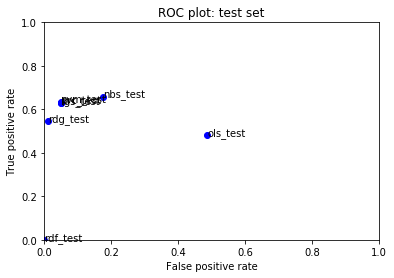

In [101]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [102]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [103]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4921848476143219


In [104]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [105]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [106]:
my_submission.shape

(153164, 2)

In [107]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation

In [108]:
my_submission.to_csv('Desktop/ml-master/final_assignment_1/toxiccomments_submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'Desktop/ml-master/final_assignment_1/toxiccomments_submission.csv'

In [ ]:
my_submission.to_csv('toxiccomments_submission.csv', index=False)